# 04. PyTorch Custom Datasets Exercises

## Resources

These exercises/solutions are based on https://www.learnpytorch.io/04_pytorch_custom_datasets/

In [1]:
# Import torch
import torch
from torch import DeviceObjType, nn

print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else (
    "mps" if torch.mps.is_available() else "cpu"
)
print(device)

2.7.1
mps


## 2. Recreate the data loading functions

### 1. Get data


In [2]:
from pathlib import Path

# Set up paths
data_path = Path("data/")
image_path = data_path  / "pizza-steak-sushi"

# Create data dir if does not exits
if image_path.is_dir():
    print(f"{image_path} already exists...")
else:
    print(f"{image_path} doesn't exist, creating...")
    image_path.mkdir(exist_ok=True)

data/pizza-steak-sushi already exists...


In [3]:
import requests

# Download data
with open(data_path / "pizza-steak-sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f"Downloading pizza-steak-sushi.zip...")
    f.write(request.content)

In [4]:
from zipfile import ZipFile

# Extract data
with ZipFile(data_path / "pizza-steak-sushi.zip", "r") as z:
    print(f"Extracting pizza-steak-sushi.zip...")
    z.extractall(image_path)

Extracting pizza-steak-sushi.zip...


### 2. Become one with the data

In [5]:
import os

def walk_through_files(dir_path) -> None:
    """Walks through dir_path printing file counts of its content"""
    for dir_path, dir_names, file_names in os.walk(dir_path):
        print(f"There are {len(dir_names)} directories and {len(file_names)} files in {dir_path}")

# Walk through data folder
walk_through_files(image_path)

There are 2 directories and 0 files in data/pizza-steak-sushi
There are 3 directories and 0 files in data/pizza-steak-sushi/test
There are 0 directories and 19 files in data/pizza-steak-sushi/test/steak
There are 0 directories and 31 files in data/pizza-steak-sushi/test/sushi
There are 0 directories and 25 files in data/pizza-steak-sushi/test/pizza
There are 3 directories and 0 files in data/pizza-steak-sushi/train
There are 0 directories and 75 files in data/pizza-steak-sushi/train/steak
There are 0 directories and 72 files in data/pizza-steak-sushi/train/sushi
There are 0 directories and 78 files in data/pizza-steak-sushi/train/pizza


In [6]:
# Setup train and testing paths
train_path = image_path / "train"
test_path = image_path / "test"

train_path, test_path

(PosixPath('data/pizza-steak-sushi/train'),
 PosixPath('data/pizza-steak-sushi/test'))

Image path: data/pizza-steak-sushi/test/pizza/2236338.jpg
Image label: pizza
Image width: 512
Image height: 512
Image size: (512, 512)


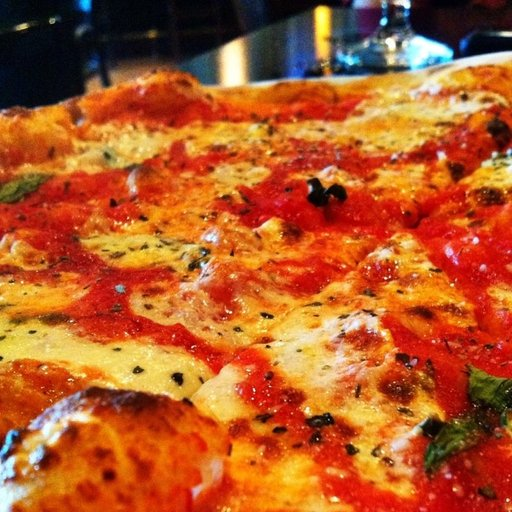

In [7]:
# Visualize an image
import random
from PIL import Image

random.seed(42)

sample_path = random.choice(list(image_path.glob("*/*/*.jpg")))
sample_image = Image.open(sample_path)
sample_label = sample_path.parent.stem

print(f"Image path: {sample_path}")
print(f"Image label: {sample_label}")
print(f"Image width: {sample_image.width}")
print(f"Image height: {sample_image.height}")
print(f"Image size: {sample_image.size}")
sample_image

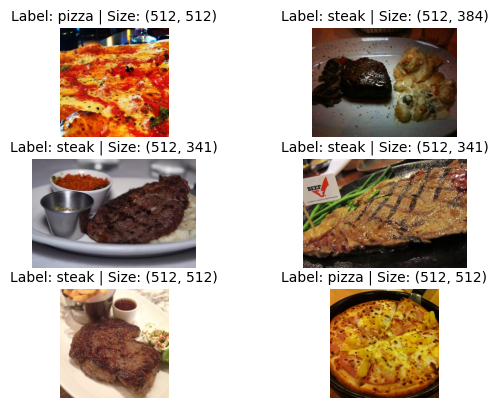

In [8]:
# Do the image visualization with matplotlib
import matplotlib.pyplot as plt

random.seed(42)

for i in range(1, 7):
    sample_path = random.choice(list(image_path.glob("*/*/*.jpg")))
    sample_label = sample_path.parent.stem
    sample_image = Image.open(sample_path)
    
    plt.subplot(3, 2, i)
    plt.imshow(sample_image)
    plt.title(f"Label: {sample_label} | Size: {sample_image.size}", fontsize=10)
    plt.axis(False)

### 2.1 Transforming data with `torchvision.transforms`

In [22]:
# Write transform for turning images into tensors
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

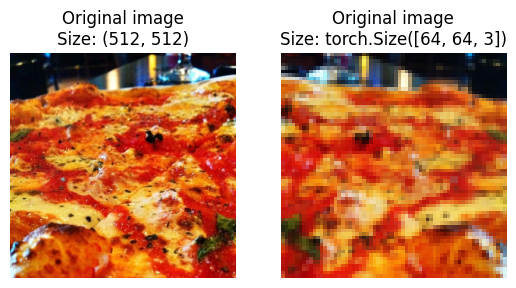

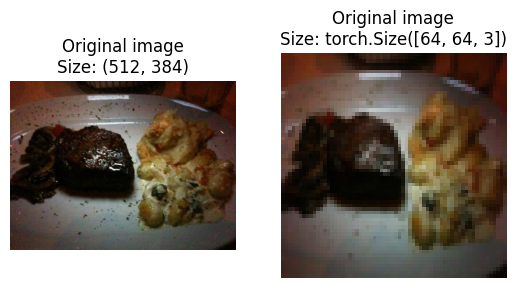

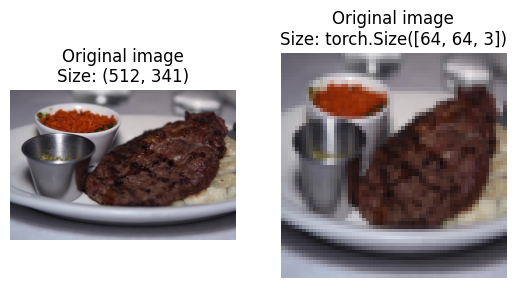

In [23]:
# Write a function to plot transformed images
def plot_and_transform_images_v1(image_path, transforms, nrows: int, seed: int=42):
    random.seed(seed)
    
    sample_paths = random.sample(list(image_path.glob("*/*/*.jpg")), k=nrows)
    
    for sample_path in sample_paths:
        sample_label = sample_path.parent.stem
        
        original_image = Image.open(sample_path)
        transformed_image = transforms(original_image).permute(1, 2, 0)
        
        fig, ax = plt.subplots(1, 2)
        
        ax[0].imshow(original_image)
        ax[0].set_title(f"Original image\nSize: {original_image.size}")
        ax[0].axis(False)
        
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Original image\nSize: {transformed_image.shape}")
        ax[1].axis(False)

plot_and_transform_images_v1(
    image_path=image_path,
    transforms=image_transform,
    nrows=3, 
    seed=42
)

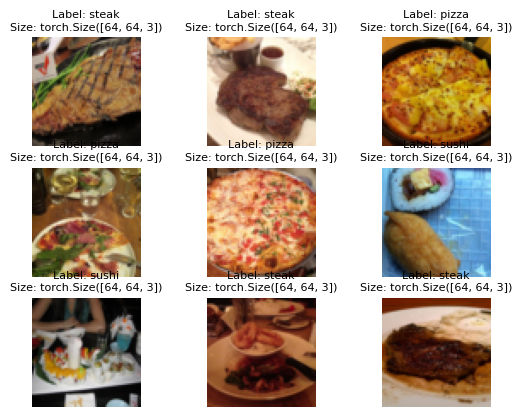

In [24]:
# Write a function to plot transformed images
def plot_and_transform_images_v2(image_path, transforms, nrows: int, ncols: int, seed: int=42):
    for i in range(1, nrows*ncols + 1):
        sample_path = random.choice(list(image_path.glob("*/*/*.jpg")))
        sampel_label = sample_path.parent.stem
        sample_image = Image.open(sample_path)
        
        sample_transformer_image = transforms(img=sample_image).permute(1, 2, 0)
        
        plt.subplot(nrows, ncols, i)
        plt.imshow(sample_transformer_image)
        plt.title(f"Label: {sampel_label}\nSize: {sample_transformer_image.shape}", fontsize=8)
        plt.axis(False)
        
plot_and_transform_images_v2(
    image_path=image_path,
    transforms=test_transform,
    nrows=3, 
    ncols=3,
    seed=42
)

### 2.2 Load image data using `ImageFolder`

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:

1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [39]:
# Use ImageFolder to create dataset(s)
from torchvision.datasets import ImageFolder

train_folder = ImageFolder(
    root=train_path,
    transform=test_transform
)

test_folder = ImageFolder(
    root=test_path,
    transform=train_transform
)

train_folder, test_folder

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza-steak-sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza-steak-sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [48]:
# Get class names as a list
classes = train_folder.classes
classes

['pizza', 'steak', 'sushi']

In [49]:
# Can also get class names as a dict
classes_to_idx = train_folder.class_to_idx
classes_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [42]:
# Check the lengths of each dataset
len(train_folder), len(test_folder)

(225, 75)

In [43]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=train_folder,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

test_dataloader = DataLoader(
    dataset=test_folder,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1175e0e10>,
 <torch.utils.data.dataloader.DataLoader at 0x11d679810>)

In [44]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(8, 3)

## 3. Recreate `model_0`

In [89]:
from torch import nn

class Model_0(nn.Module):
    def __init__(self, in_features: int, hidden_units: int, out_features: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_features,
                out_channels=hidden_units,
                kernel_size=(3, 3),
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=(3, 3),
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            ),   
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=(3, 3),
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=(3, 3),
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            ),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 16 * 16,
                out_features=out_features,
            )
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        # print(x.shape)
        
        x = self.conv_block_2(x)
        # print(x.shape)
        
        x = self.classifier(x)
        # print(x.shape)
        
        return x

model_0 = Model_0(
    in_features=3,
    hidden_units=8,
    out_features=len(classes)
).to(device)

model_0

Model_0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=3, bias=True)
  )
)

In [90]:
model_0

Model_0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=3, bias=True)
  )
)

In [67]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

model_0(image_batch)

torch.Size([32, 8, 32, 32])
torch.Size([32, 8, 16, 16])
torch.Size([32, 3])


tensor([[-0.0279, -0.0109, -0.0121],
        [-0.0313, -0.0099, -0.0116],
        [-0.0324, -0.0083, -0.0095],
        [-0.0320, -0.0097, -0.0101],
        [-0.0326, -0.0085, -0.0083],
        [-0.0321, -0.0078, -0.0037],
        [-0.0331, -0.0096, -0.0098],
        [-0.0325, -0.0060, -0.0103],
        [-0.0303, -0.0111, -0.0060],
        [-0.0340, -0.0072, -0.0078],
        [-0.0324, -0.0093, -0.0112],
        [-0.0281, -0.0074, -0.0111],
        [-0.0335, -0.0067, -0.0096],
        [-0.0318, -0.0082, -0.0138],
        [-0.0327, -0.0106, -0.0096],
        [-0.0321, -0.0077, -0.0111],
        [-0.0341, -0.0074, -0.0101],
        [-0.0317, -0.0097, -0.0088],
        [-0.0290, -0.0125, -0.0079],
        [-0.0341, -0.0067, -0.0081],
        [-0.0327, -0.0087, -0.0105],
        [-0.0307, -0.0093, -0.0130],
        [-0.0325, -0.0080, -0.0085],
        [-0.0306, -0.0089, -0.0102],
        [-0.0339, -0.0097, -0.0108],
        [-0.0326, -0.0081, -0.0100],
        [-0.0349, -0.0080, -0.0118],
 

## 4. Create training and testing functions for `model_0`

In [99]:
from typing import Tuple

def train_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device="cpu",
) -> Tuple[float, float]:
    # Send model to target device
    model.to(device)
    
    # Put the model in train mode
    model.train()
    
    # Setup train loss and train accuracy
    train_loss, train_accuracy = 0, 0
    
    # Loop through data loader and data batches
    for X, y in dataloader:
        # Send data to target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred_logits = model(X)
        y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)

        # 2. Calculate and accumulate loss and accuracy
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()
        
        accuracy = ((y_pred_labels == y).sum().item() / len(y_pred_logits))
        train_accuracy += accuracy
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
    # Adjust metrics to get average loss and average accuracy per batch
    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)
    
    return train_loss, train_accuracy

In [100]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device="cpu",
) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval()
    
    # Setup the test loss and test accuracy
    test_loss, test_accuracy = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for X, y in dataloader:
            
            # Send data to target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            y_pred_logits = model(X)
            y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
            
            # 2. Calculate and accumulate loss and accuracy
            loss = loss_fn(y_pred_logits, y)
            test_loss += loss.item()
            
            accuracy = ((y_pred_labels == y).sum().item() / len(y_pred_logits))
            test_accuracy += accuracy
    
    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_accuracy /= len(dataloader)
    
    return test_loss, test_accuracy

In [101]:
from tqdm.auto import tqdm

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int = 5,
    device="cpu"
):
    # Create results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }
    
    # Loop through the training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # Train step
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            device=device,
        )
        
        # Test step
        test_loss, test_acc = test_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            device=device,
        )
        
        # Print out what's happening
        print(
            f"Epoch: {epoch} | ",
            f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.3f}%",
            f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.3f}%"
        )
        
        # Update the results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    # Return the results dictionary
    return results

## 5. Try training the model for 5, 20 and 50 epochs

In [125]:
def plot_results(results):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(results["train_loss"], c="r", label="Train loss")
    plt.plot(results["test_loss"], c="b", label="Test loss")
    plt.title("Train vs test loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(results["train_acc"], c="r", label="Train accuracy")
    plt.plot(results["test_acc"], c="b", label="Test accuracy")
    plt.title("Train vs test acc")
    plt.legend()
    

In [105]:
# Train for 5 epochs
model_5_epochs = Model_0(
    in_features=3,
    hidden_units=16,
    out_features=len(classes),
)

torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_5_epochs.parameters(),
    lr=0.001
)

results_5_epochs = train(
    model=model_5_epochs,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 |  Train loss: 1.1071 | Train acc: 0.250% Test loss: 1.0944 | Test acc: 0.426%
Epoch: 1 |  Train loss: 1.0811 | Train acc: 0.426% Test loss: 1.0784 | Test acc: 0.426%
Epoch: 2 |  Train loss: 1.1219 | Train acc: 0.305% Test loss: 1.0901 | Test acc: 0.359%
Epoch: 3 |  Train loss: 1.1047 | Train acc: 0.434% Test loss: 1.0173 | Test acc: 0.559%
Epoch: 4 |  Train loss: 1.0501 | Train acc: 0.461% Test loss: 0.9912 | Test acc: 0.586%


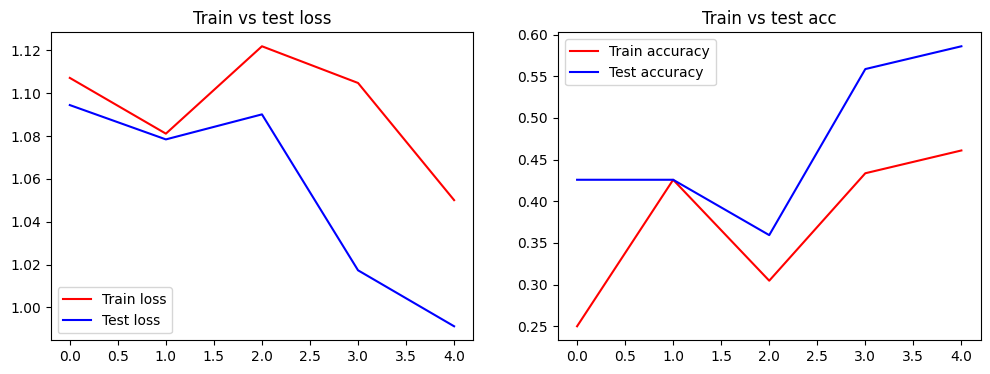

In [127]:
plot_results(results_5_epochs)

In [106]:
# Train for 20 epochs
model_20_epochs = Model_0(
    in_features=3,
    hidden_units=16,
    out_features=len(classes),
)

torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_20_epochs.parameters(),
    lr=0.001
)

results_20_epochs = train(
    model=model_20_epochs,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20,
    device=device
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 |  Train loss: 1.1064 | Train acc: 0.250% Test loss: 1.0963 | Test acc: 0.426%
Epoch: 1 |  Train loss: 1.0868 | Train acc: 0.426% Test loss: 1.0843 | Test acc: 0.426%
Epoch: 2 |  Train loss: 1.1201 | Train acc: 0.305% Test loss: 1.1160 | Test acc: 0.305%
Epoch: 3 |  Train loss: 1.0788 | Train acc: 0.418% Test loss: 1.0736 | Test acc: 0.426%
Epoch: 4 |  Train loss: 1.1049 | Train acc: 0.305% Test loss: 1.0602 | Test acc: 0.336%
Epoch: 5 |  Train loss: 1.0871 | Train acc: 0.402% Test loss: 1.0725 | Test acc: 0.418%
Epoch: 6 |  Train loss: 1.0626 | Train acc: 0.461% Test loss: 1.0021 | Test acc: 0.488%
Epoch: 7 |  Train loss: 1.0356 | Train acc: 0.426% Test loss: 1.0010 | Test acc: 0.422%
Epoch: 8 |  Train loss: 1.0010 | Train acc: 0.438% Test loss: 0.9729 | Test acc: 0.637%
Epoch: 9 |  Train loss: 0.9823 | Train acc: 0.480% Test loss: 0.9075 | Test acc: 0.602%
Epoch: 10 |  Train loss: 0.9691 | Train acc: 0.465% Test loss: 0.9858 | Test acc: 0.500%
Epoch: 11 |  Train loss: 0.9518

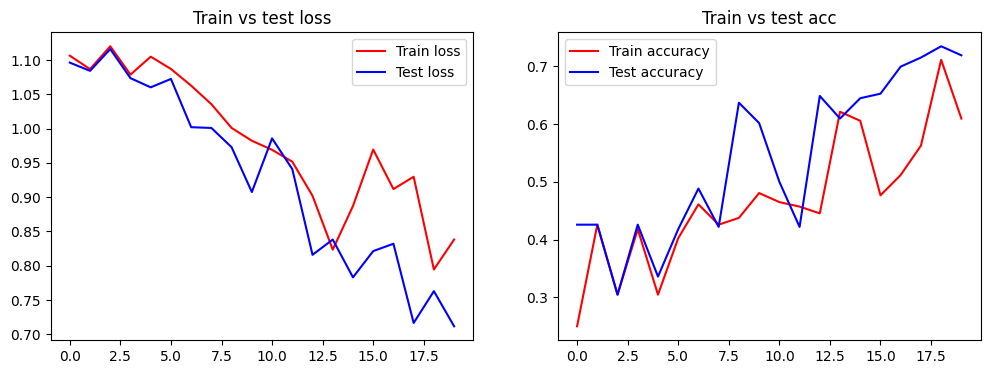

In [128]:
plot_results(results_20_epochs)

In [107]:
# Train for 50 epochs
model_50_epochs = Model_0(
    in_features=3,
    hidden_units=16,
    out_features=len(classes),
)

torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_50_epochs.parameters(),
    lr=0.001
)

results_50_epochs = train(
    model=model_50_epochs,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=50,
    device=device
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 |  Train loss: 1.1071 | Train acc: 0.250% Test loss: 1.0944 | Test acc: 0.426%
Epoch: 1 |  Train loss: 1.0811 | Train acc: 0.426% Test loss: 1.0784 | Test acc: 0.426%
Epoch: 2 |  Train loss: 1.1219 | Train acc: 0.305% Test loss: 1.0901 | Test acc: 0.359%
Epoch: 3 |  Train loss: 1.1047 | Train acc: 0.434% Test loss: 1.0173 | Test acc: 0.559%
Epoch: 4 |  Train loss: 1.0501 | Train acc: 0.461% Test loss: 0.9912 | Test acc: 0.586%
Epoch: 5 |  Train loss: 1.0601 | Train acc: 0.461% Test loss: 0.9264 | Test acc: 0.625%
Epoch: 6 |  Train loss: 0.9326 | Train acc: 0.539% Test loss: 0.8521 | Test acc: 0.680%
Epoch: 7 |  Train loss: 0.8609 | Train acc: 0.598% Test loss: 0.8011 | Test acc: 0.625%
Epoch: 8 |  Train loss: 0.9387 | Train acc: 0.520% Test loss: 0.8118 | Test acc: 0.637%
Epoch: 9 |  Train loss: 0.9115 | Train acc: 0.594% Test loss: 0.7855 | Test acc: 0.691%
Epoch: 10 |  Train loss: 0.8487 | Train acc: 0.660% Test loss: 0.8032 | Test acc: 0.684%
Epoch: 11 |  Train loss: 0.8032

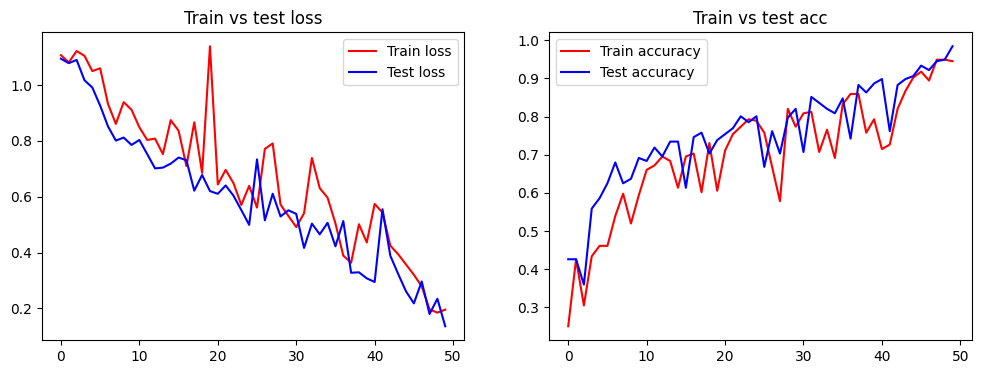

In [130]:
plot_results(results_50_epochs)

## 6. Double the number of hidden units in your model and train it for 20 epochs,

In [108]:
# Double the number of hidden units and train for 20 epochs
model_double_hidden_units = Model_0(
    in_features=3,
    hidden_units=32,
    out_features=len(classes),
)

torch.manual_seed(42)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_double_hidden_units.parameters(),
    lr=0.001
)

results_double_hidden_units = train(
    model=model_double_hidden_units,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20,
    device=device,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 |  Train loss: 1.1105 | Train acc: 0.223% Test loss: 1.0923 | Test acc: 0.426%
Epoch: 1 |  Train loss: 1.0799 | Train acc: 0.426% Test loss: 1.0785 | Test acc: 0.426%
Epoch: 2 |  Train loss: 1.1319 | Train acc: 0.305% Test loss: 1.1156 | Test acc: 0.305%
Epoch: 3 |  Train loss: 1.1037 | Train acc: 0.305% Test loss: 1.0768 | Test acc: 0.391%
Epoch: 4 |  Train loss: 1.1012 | Train acc: 0.281% Test loss: 1.0823 | Test acc: 0.320%
Epoch: 5 |  Train loss: 1.0884 | Train acc: 0.367% Test loss: 1.0609 | Test acc: 0.410%
Epoch: 6 |  Train loss: 1.0562 | Train acc: 0.430% Test loss: 0.9604 | Test acc: 0.645%
Epoch: 7 |  Train loss: 1.0200 | Train acc: 0.441% Test loss: 0.9021 | Test acc: 0.430%
Epoch: 8 |  Train loss: 0.9628 | Train acc: 0.484% Test loss: 0.8783 | Test acc: 0.625%
Epoch: 9 |  Train loss: 0.9232 | Train acc: 0.605% Test loss: 0.8030 | Test acc: 0.691%
Epoch: 10 |  Train loss: 0.8627 | Train acc: 0.527% Test loss: 1.4265 | Test acc: 0.457%
Epoch: 11 |  Train loss: 0.8601

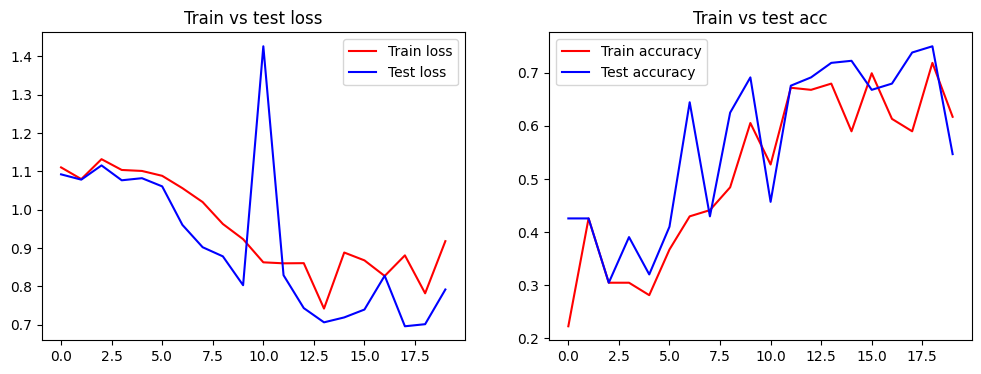

In [131]:
plot_results(results_double_hidden_units)

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs

In [ ]:
from torch.utils.data import Dataset

import pathlib
data_dir = pathlib.Path("../data")


# Get training data
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              # transform=transforms.ToTensor(),
                              download=True)

# Get testing data
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             # transform=transforms.ToTensor(),
                             download=True)
